In [1]:
import os

from collections import defaultdict

import tqdm
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn

import vari
import vari.datasets
import vari.models
import vari.inference
from vari.layers import GaussianSample, BernoulliSample

from sklearn.datasets import make_circles

In [2]:
experiments_dir = '/nas/experiments/sacred/models/'
data_root = '/home/jdh/repos/vari/torch_data'
mpl.style.use('default')

## Select models and data

In [3]:
run_ids_all_labels = dict(
    MNISTBinarized=dict(
        vae=6243,
        hvae=6263,
        avae=6278
    ),
#    FashionMNISTBinarized=dict(  # dynamic
#        vae=6253,
#        hvae=6256,
#        avae=6286
#    ),
    FashionMNISTBinarized=dict(   # deterministic
        vae=6338,
        hvae=6339,
        avae=6340
    )
)

run_ids_excluded_labels = dict(
    MNISTBinarized=dict(
        vae={'4': 6244, '8': 6250},
        hvae={'4': 6245, '8': 6251},
        avae={'4': 6246, '8': 6252}
    ),
    FashionMNISTBinarized=dict(
        vae={'0': 6247, '8': 6255},
        hvae={'0': 6248, '8': 6264},
        avae={'0': 6249, '8': 6284}
    )
)

#run_ids = dict(
#    vae=6209,
#    hvae=6203,
##    avae=6219,
#)

#dataset_name = 'spirals'
#run_ids = dict(
#    vae=6211,
#    avae=6220,
#    hvae=6205,
#)

## Get datasets

In [4]:
mnist_train = vari.datasets.MNISTBinarized(split='train', preprocess='static', exclude_labels=[], root=data_root)
mnist_test1 = vari.datasets.MNISTBinarized(split='test', preprocess='static', exclude_labels=[], root=data_root)

In [5]:
fashion_mnist_train = vari.datasets.FashionMNISTBinarized(split='train', preprocess='deterministic', exclude_labels=[], root=data_root)
fashion_mnist_test1 = vari.datasets.FashionMNISTBinarized(split='test', preprocess='deterministic', exclude_labels=[], root=data_root)

### Visualize dataset

In [6]:
def plot_image_matrix(images, ax):
    rows = int(np.sqrt(len(images)))
    cols = rows
    image_rows = []
    for i in range(rows):
        image_rows += [np.concatenate(images[i*cols:(i+1)*cols], axis=1)]
    image_matrix = np.concatenate(image_rows, axis=0)
    ax.imshow(image_matrix, cmap='binary_r')
    ax.axis('off')

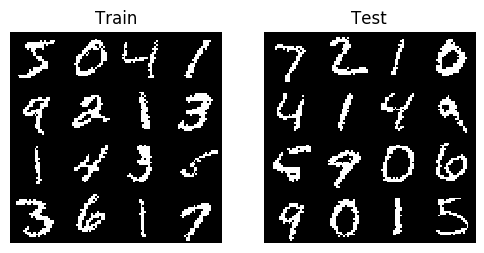

In [7]:
start_idx = 0
n_images = 4 * 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12))
plot_image_matrix(mnist_train.examples[start_idx: start_idx + n_images], ax1)
plot_image_matrix(mnist_test1.examples[start_idx: start_idx + n_images], ax2)
ax1.set_title('Train')
ax2.set_title('Test');

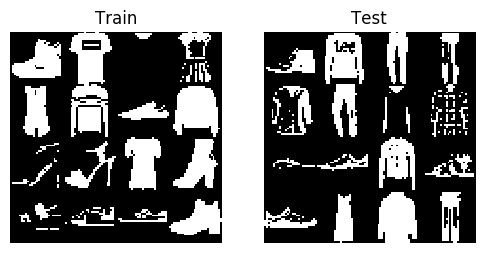

In [8]:
start_idx = 0
n_images = 4 * 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12))
plot_image_matrix(fashion_mnist_train.examples[start_idx: start_idx + n_images], ax1)
plot_image_matrix(fashion_mnist_test1.examples[start_idx: start_idx + n_images], ax2)
ax1.set_title('Train')
ax2.set_title('Test');

## Load models trained on all labels

In [9]:
def get_data(train_data):
    if train_data == 'MNISTBinarized':
        x_train = mnist_train.examples.reshape(-1, 784)
        x_test1 = mnist_test1.examples.reshape(-1, 784)
        x_test2 = fashion_mnist_test1.examples.reshape(-1, 784)
        y_train = mnist_train.labels.argmax(axis=1)
        y_test1 = mnist_test1.labels.argmax(axis=1)
        y_test2 = fashion_mnist_test1.labels.argmax(axis=1)
    elif train_data == 'FashionMNISTBinarized':
        x_train = fashion_mnist_train.examples.reshape(-1, 784)
        x_test1 = fashion_mnist_test1.examples.reshape(-1, 784)
        x_test2 = mnist_test1.examples.reshape(-1, 784)
        y_train = fashion_mnist_train.labels.argmax(axis=1)
        y_test1 = fashion_mnist_test1.labels.argmax(axis=1)
        y_test2 = mnist_test1.labels.argmax(axis=1)
    return x_train, x_test1, x_test2, y_train, y_test1, y_test2

In [10]:
def load_models(run_ids):
    latent_space_models = dict()
    for model_abbr, model_name in [('vae', 'VariationalAutoencoder'),
                                   ('avae', 'AuxilliaryVariationalAutoencoder'),
                                   ('hvae', 'HierarchicalVariationalAutoencoder')]:
        run_id = str(run_ids[model_abbr])

        model = getattr(vari.models.vae, model_name)
        try:
            # Load the saved kwargs
            kwargs = torch.load(
                os.path.join(experiments_dir, run_id, 'model_kwargs.pkl')
            )
            model = model(**kwargs)
        except Exception as exc:
            # Try default config
            kwargs = vari.models.get_default_model_config(model_name, train_data)
            model = model(**kwargs)

        try:
            model.load_state_dict(torch.load(
                os.path.join(experiments_dir, run_id, 'model_state_dict.pkl'),
                map_location=torch.device('cpu')
            ))
            latent_space_models[model_abbr] = model
            print(f'Loaded {model_abbr.upper()} ID {run_id}')
        except Exception as exc:
            print(model_abbr, exc)
    return latent_space_models

In [11]:
train_data = 'MNISTBinarized'
#train_data = 'FashionMNISTBinarized'
x_train, x_test1, x_test2, y_train, y_test1, y_test2 = get_data(train_data)

In [12]:
print(train_data)
latent_space_models = load_models(run_ids_all_labels[train_data])
print('Loaded:', latent_space_models.keys())

MNISTBinarized
Loaded VAE ID 6243
Loaded AVAE ID 6278
Loaded HVAE ID 6263
Loaded: dict_keys(['vae', 'avae', 'hvae'])


## Visualize latent space

In [13]:
def plot_vectors(vectors, fig=None, ax=None, figsize=(20, 20), color='C0', alpha=0.4, label='train', label_ids=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
        
    if label_ids is not None:
        for i in np.unique(label_ids):
            ax.scatter(vectors[label_ids==i, 0],
                       vectors[label_ids==i, 1],
                       s=2.5, c=f'C{i}', alpha=alpha, label=f"{label}:class{i}")
    else:
        ax.scatter(vectors[:,0], vectors[:,1], c=color, alpha=alpha, label=label)
    #ax1.scatter(vae_qz_mu_x2[:,0], vae_qz_mu_x2[:,1], c=[test1_0], alpha=0.4, label="test1")
    #ax.plot(mesh[:,0], mesh[:,1], c='black', alpha=.2, linewidth=.5)
    #ax.scatter(mesh[:,0], mesh[:,1], c=[(.8, .8, .8, .8)], alpha=.5, s=5.)
    # ax1.axis('off')
    ax.legend()
    return fig, ax

### VAE

In [16]:
vae = latent_space_models['vae']
with torch.no_grad():
    vae_qz_x_train, (vae_qz_mu_x_train, vae_qz_log_var_x_train) = vae.encode(torch.FloatTensor(x_train))
    vae_qz_x_test1, (vae_qz_mu_x_test1, vae_qz_log_var_x_test1) = vae.encode(torch.FloatTensor(x_test1))
    vae_qz_x_test2, (vae_qz_mu_x_test2, vae_qz_log_var_x_test2) = vae.encode(torch.FloatTensor(x_test2))

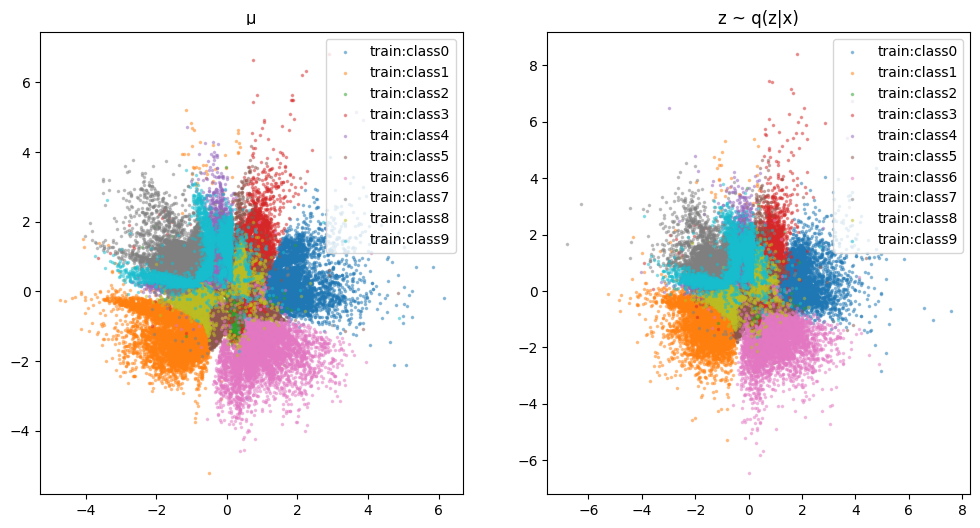

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_vectors(vae_qz_mu_x_train, label_ids=y_train, ax=ax1)
plot_vectors(vae_qz_x_train, label_ids=y_train, ax=ax2)
ax1.set_title('µ')
ax2.set_title('z ~ q(z|x)')
plt.show()

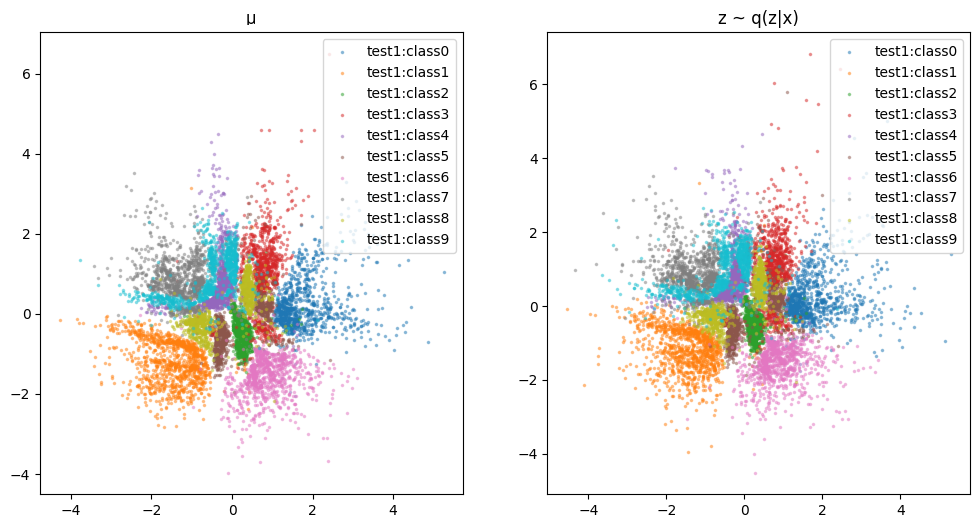

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_vectors(vae_qz_mu_x_test1, label_ids=y_test1, ax=ax1, label='test1')
plot_vectors(vae_qz_x_test1, label_ids=y_test1, ax=ax2, label='test1')
ax1.set_title('µ')
ax2.set_title('z ~ q(z|x)')
plt.show()

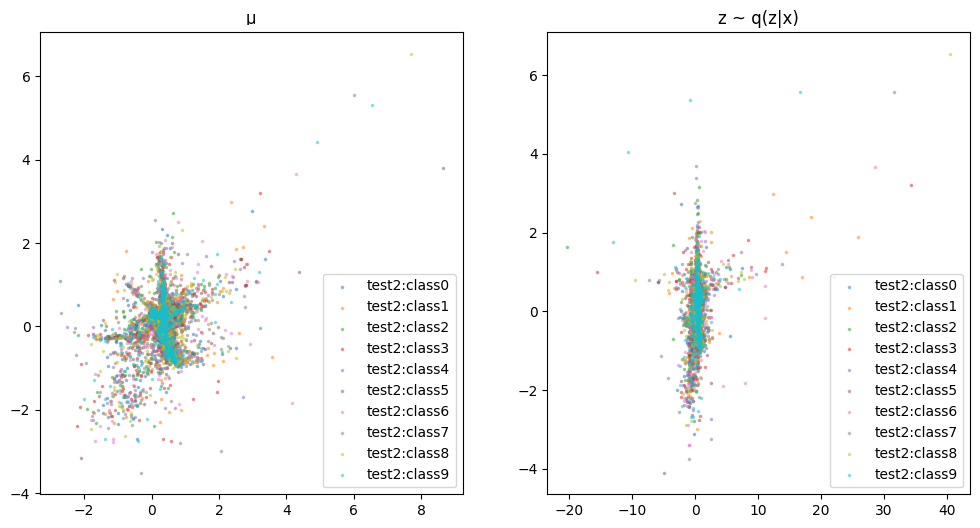

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_vectors(vae_qz_mu_x_test2, label_ids=y_test1, ax=ax1, label='test2')
plot_vectors(vae_qz_x_test2, label_ids=y_test1, ax=ax2, label='test2')
ax1.set_title('µ')
ax2.set_title('z ~ q(z|x)')
plt.show()

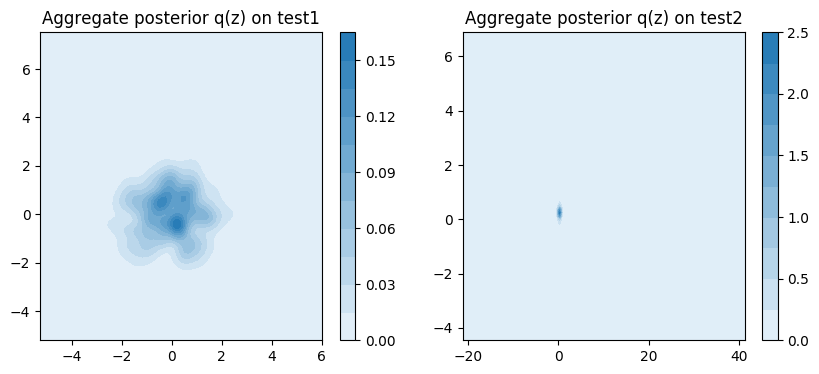

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Aggregate posterior q(z) on test1')
seaborn.kdeplot(vae_qz_x_test1[:, 0].numpy(),
                data2=vae_qz_x_test1[:, 1].numpy(),
                shade=True,
                cbar=True,
                ax=ax1)
ax2.set_title('Aggregate posterior q(z) on test2')
seaborn.kdeplot(vae_qz_x_test2[:, 0].numpy(),
                data2=vae_qz_x_test2[:, 1].numpy(),
                shade=True,
                cbar=True,
                ax=ax2)

### AVAE

In [19]:
avae = latent_space_models['avae']
with torch.no_grad():
    (avae_qz_x_train, (avae_qz_mu_x_train, avae_qz_log_var_x_train)), (avae_qa_x_train, (avae_qa_mu_x_train, avae_qa_log_var_x_train)) = avae.encode(torch.FloatTensor(x_train))
    (avae_qz_x_test1, (avae_qz_mu_x_test1, avae_qz_log_var_x_test1)), (avae_qa_x_test1, (avae_qa_mu_x_test1, avae_qa_log_var_x_test1)) = avae.encode(torch.FloatTensor(x_test1))
    (avae_qz_x_test2, (avae_qz_mu_x_test2, avae_qz_log_var_x_test2)), (avae_qa_x_test2, (avae_qa_mu_x_test2, avae_qa_log_var_x_test2)) = avae.encode(torch.FloatTensor(x_test2))

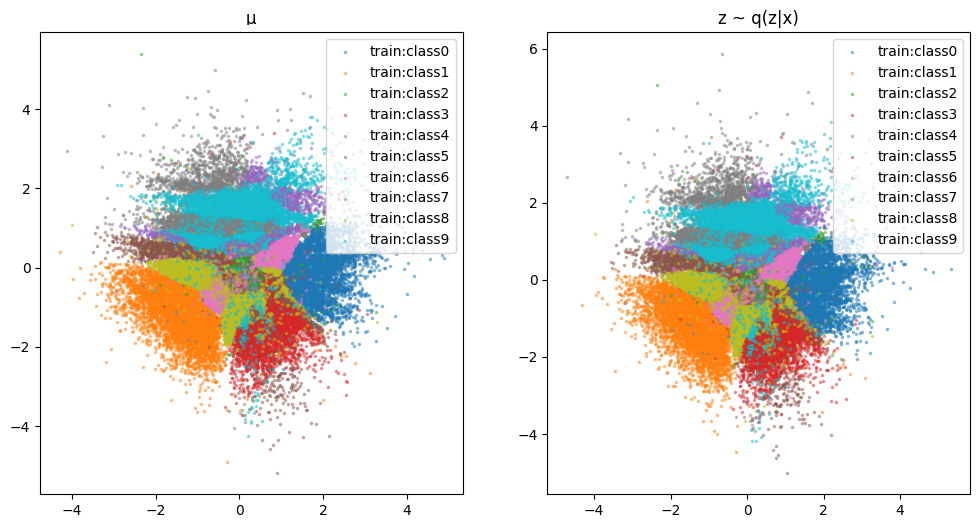

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_vectors(avae_qz_mu_x_train, label_ids=y_train, ax=ax1)
plot_vectors(avae_qz_x_train, label_ids=y_train, ax=ax2)
ax1.set_title('µ')
ax2.set_title('z ~ q(z|x)')
plt.show()

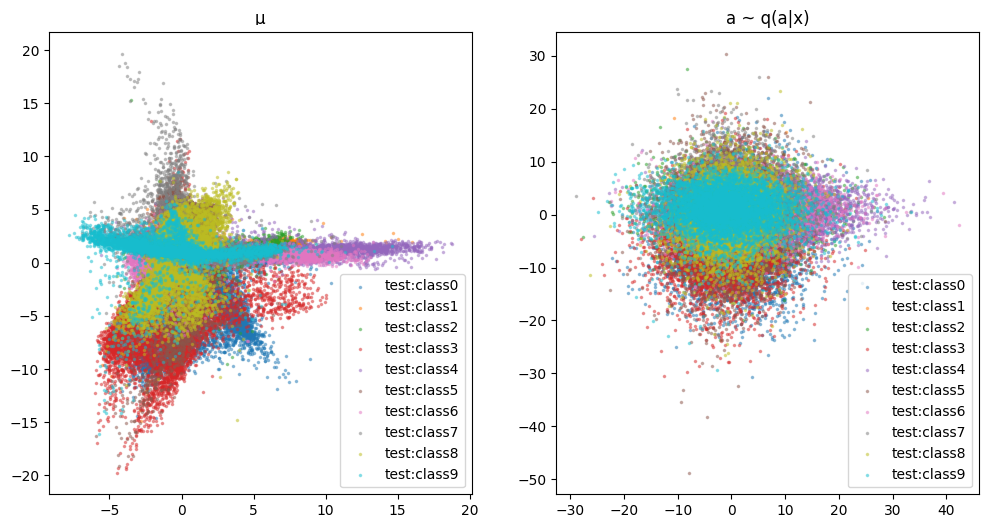

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_vectors(avae_qa_mu_x_train, label_ids=y_train, ax=ax1, label='test')
plot_vectors(avae_qa_x_train, label_ids=y_train, ax=ax2, label='test')
ax1.set_title('µ')
ax2.set_title('a ~ q(a|x)')
plt.show()

(-4, 4)

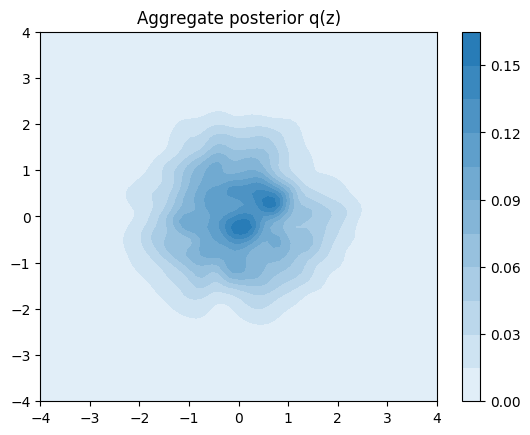

In [22]:
fig, ax1 = plt.subplots(1, 1)
ax1.set_title('Aggregate posterior q(z)')
seaborn.kdeplot(avae_qz_x_train[:, 0].numpy(),
                data2=avae_qz_x_train[:, 1].numpy(),
                shade=True,
                cbar=True,
                ax=ax1)
ax1.set_xlim([-4, 4])
ax1.set_ylim([-4, 4])

### HVAE

In [23]:
hvae = latent_space_models['hvae']
with torch.no_grad():
    latents_train = hvae.encode(torch.FloatTensor(x_train))
    latents_test1 = hvae.encode(torch.FloatTensor(x_test1))
    latents_test2 = hvae.encode(torch.FloatTensor(x_test2))

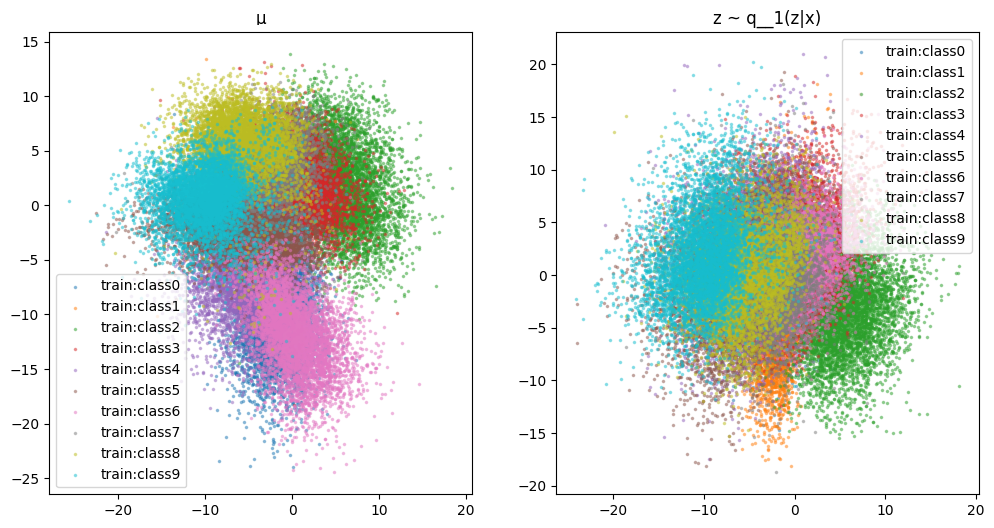

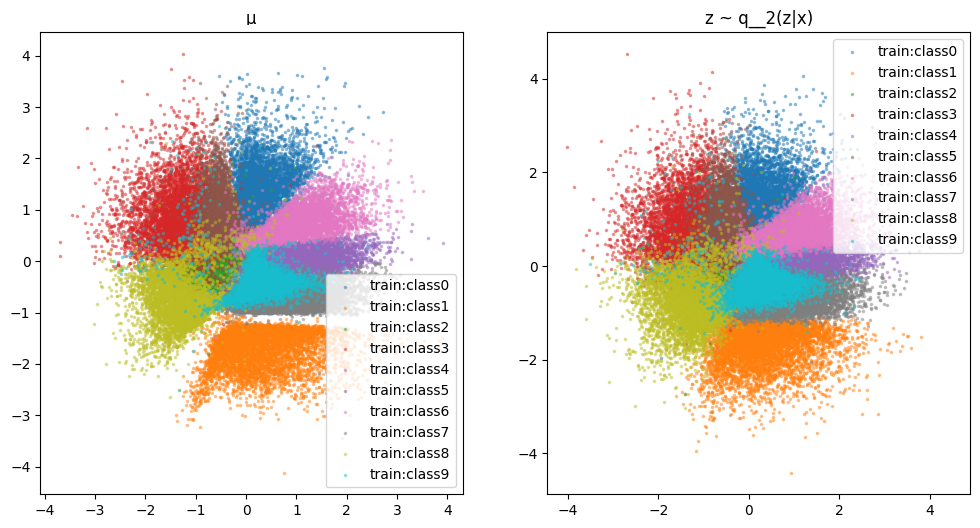

In [24]:
non_2d_elements = [0, 3]
for i_layer in range(len(latents_train)):
    hvae_qz_x_train = latents_train[i_layer][0]
    hvae_qz_mu_x_train = latents_train[i_layer][1][0]
    
    if hvae_qz_x_train.shape[1] > 2:
        hvae_qz_x_train = hvae_qz_x_train[:, non_2d_elements]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    plot_vectors(hvae_qz_mu_x_train, label_ids=y_train, ax=ax1)
    plot_vectors(hvae_qz_x_train, label_ids=y_train, ax=ax2)
    ax1.set_title('µ')
    ax2.set_title(f'z ~ q__{i_layer+1}(z|x)')
    plt.show()

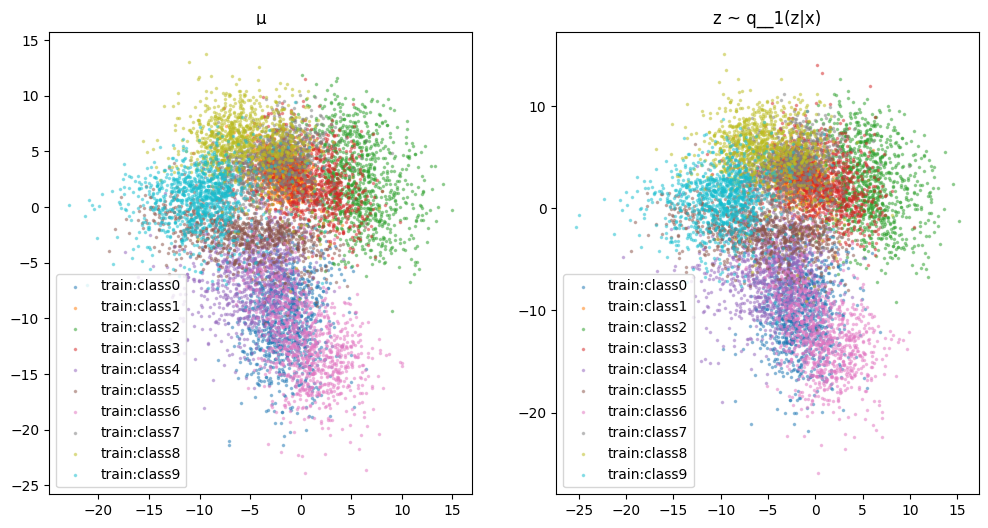

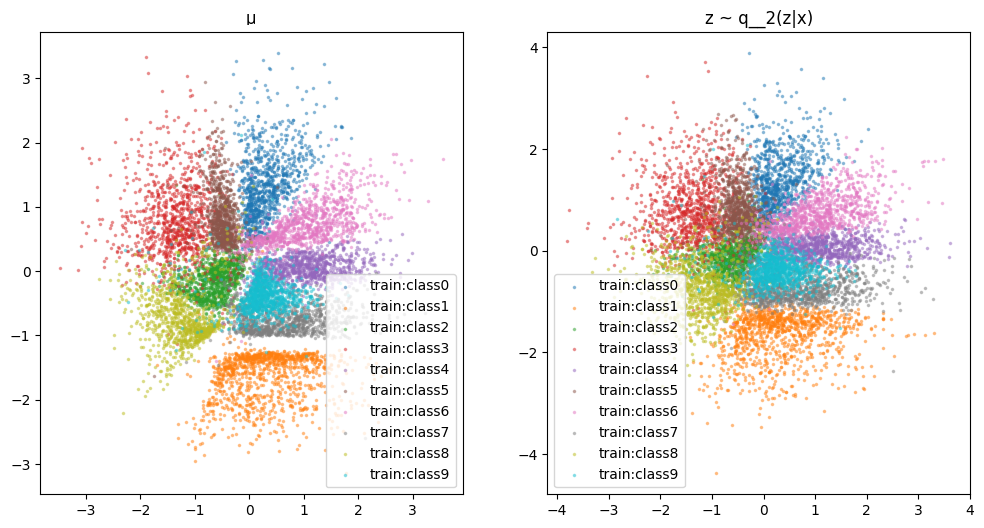

In [25]:
non_2d_elements = [0, 1]
for i_layer in range(len(latents_test1)):
    hvae_qz_x_test1 = latents_test1[i_layer][0]
    hvae_qz_mu_x_test1 = latents_test1[i_layer][1][0]
    
    if hvae_qz_x_test1.shape[1] > 2:
        hvae_qz_x_test1 = hvae_qz_x_test1[:, non_2d_elements]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    plot_vectors(hvae_qz_mu_x_test1, label_ids=y_test1, ax=ax1)
    plot_vectors(hvae_qz_x_test1, label_ids=y_test1, ax=ax2)
    ax1.set_title('µ')
    ax2.set_title(f'z ~ q__{i_layer+1}(z|x)')
    plt.show()

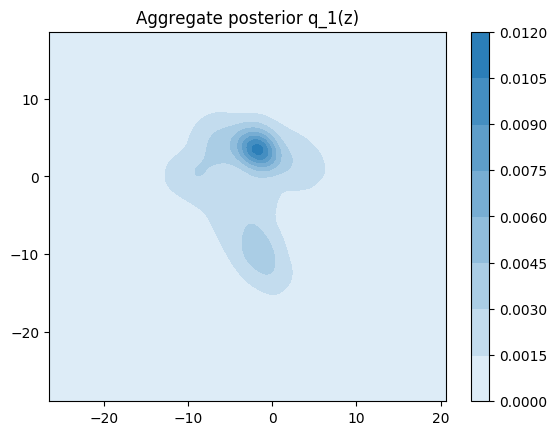

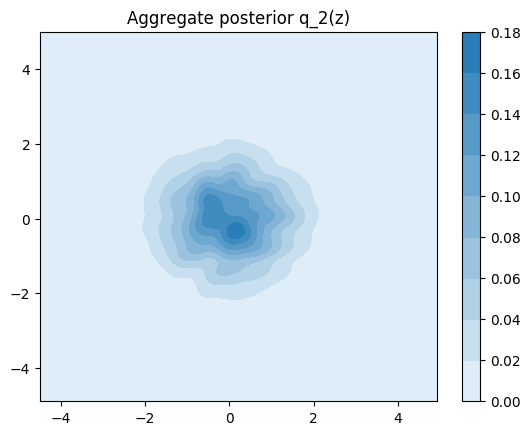

In [26]:
for i_layer in range(len(latents_train)):
    hvae_qz_x_train = latents_train[i_layer][0]
    hvae_qz_mu_x_train = latents_train[i_layer][1][0]
    
    fig, ax1 = plt.subplots(1, 1)
    ax1.set_title(f'Aggregate posterior q_{i_layer+1}(z)')
    seaborn.kdeplot(hvae_qz_x_train[:, 0].numpy(),
                    data2=hvae_qz_x_train[:, 1].numpy(),
                    shade=True,
                    cbar=True,
                    ax=ax1)
    #ax1.set_xlim([-4, 4])
    #ax1.set_ylim([-4, 4])

## Visualize reconstruction

In [27]:
n_samples = 10*10
x_originals = torch.FloatTensor(x_test1[:n_samples])
with torch.no_grad():
    vae_p_x_reconstructions, vae_p_x_parameters = vae(x_originals)
    hvae_p_x_reconstructions, vae_p_x_parameters = hvae(x_originals)
    avae_p_x_reconstructions, vae_p_x_parameters = avae(x_originals)

In [28]:
x_originals = x_originals.reshape(x_originals.shape[0], 28, 28)
x_originals = [x for x in x_originals]

Text(0.5, 1.0, 'Reconstructions')

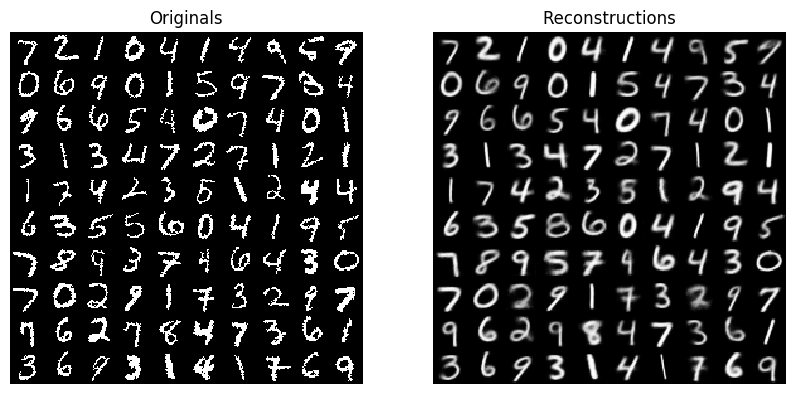

In [29]:
vae_p_x_reconstructions = vae_p_x_reconstructions.reshape(vae_p_x_reconstructions.shape[0], 28, 28)
vae_p_x_reconstructions = [x for x in vae_p_x_reconstructions]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
plot_image_matrix(x_originals, ax1)
plot_image_matrix(vae_p_x_reconstructions, ax2)
ax1.set_title('Originals')
ax2.set_title('Reconstructions')

Text(0.5, 1.0, 'Reconstructions')

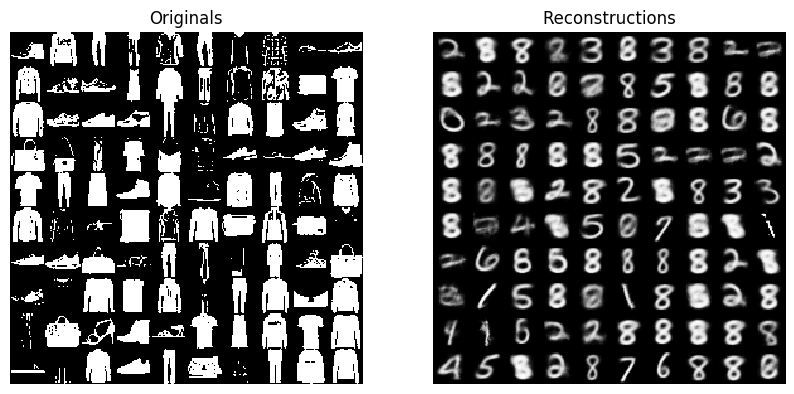

In [20]:
n_samples = 10*10
x_originals = torch.FloatTensor(x_test2[:n_samples])
with torch.no_grad():
    vae_p_x_reconstructions, vae_p_x_parameters = vae(x_originals)
    
x_originals = x_originals.reshape(x_originals.shape[0], 28, 28)
x_originals = [x for x in x_originals]

vae_p_x_reconstructions = vae_p_x_reconstructions.reshape(vae_p_x_reconstructions.shape[0], 28, 28)
vae_p_x_reconstructions = [x for x in vae_p_x_reconstructions]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
plot_image_matrix(x_originals, ax1)
plot_image_matrix(vae_p_x_reconstructions, ax2)
ax1.set_title('Originals')
ax2.set_title('Reconstructions')

Text(0.5, 1.0, 'Reconstructions')

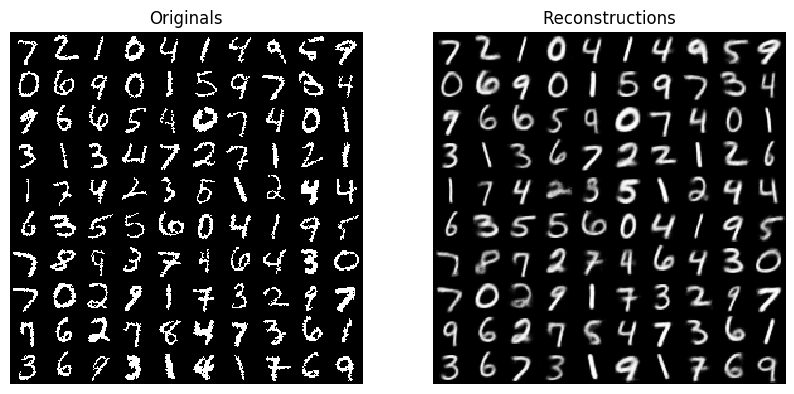

In [30]:
avae_p_x_reconstructions = avae_p_x_reconstructions.reshape(avae_p_x_reconstructions.shape[0], 28, 28)
avae_p_x_reconstructions = [x for x in avae_p_x_reconstructions]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
plot_image_matrix(x_originals, ax1)
plot_image_matrix(avae_p_x_reconstructions, ax2)
ax1.set_title('Originals')
ax2.set_title('Reconstructions')

Text(0.5, 1.0, 'Reconstructions')

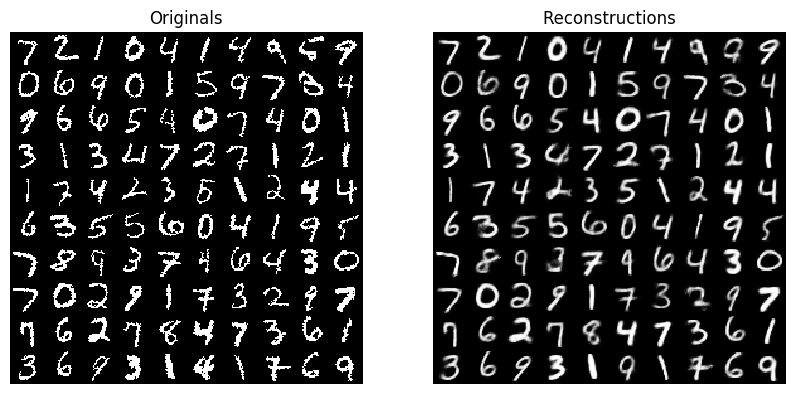

In [31]:
hvae_p_x_reconstructions = hvae_p_x_reconstructions.reshape(hvae_p_x_reconstructions.shape[0], 28, 28)
hvae_p_x_reconstructions = [x for x in hvae_p_x_reconstructions]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
plot_image_matrix(x_originals, ax1)
plot_image_matrix(hvae_p_x_reconstructions, ax2)
ax1.set_title('Originals')
ax2.set_title('Reconstructions')

## Visualize sampling

In [32]:
n_samples = 100
p_z_samples = torch.randn((n_samples, 2))

In [33]:
with torch.no_grad():
    vae_p_x_samples, vae_p_x_parameters = vae.sample(p_z_samples)
    hvae_p_x_samples, hvae_p_x_parameters = hvae.sample(p_z_samples)
    avae_p_x_samples, avae_p_x_parameters = avae.sample(p_z_samples)

Text(0.5, 1.0, 'Samples, x ~\xa0p(x|z)')

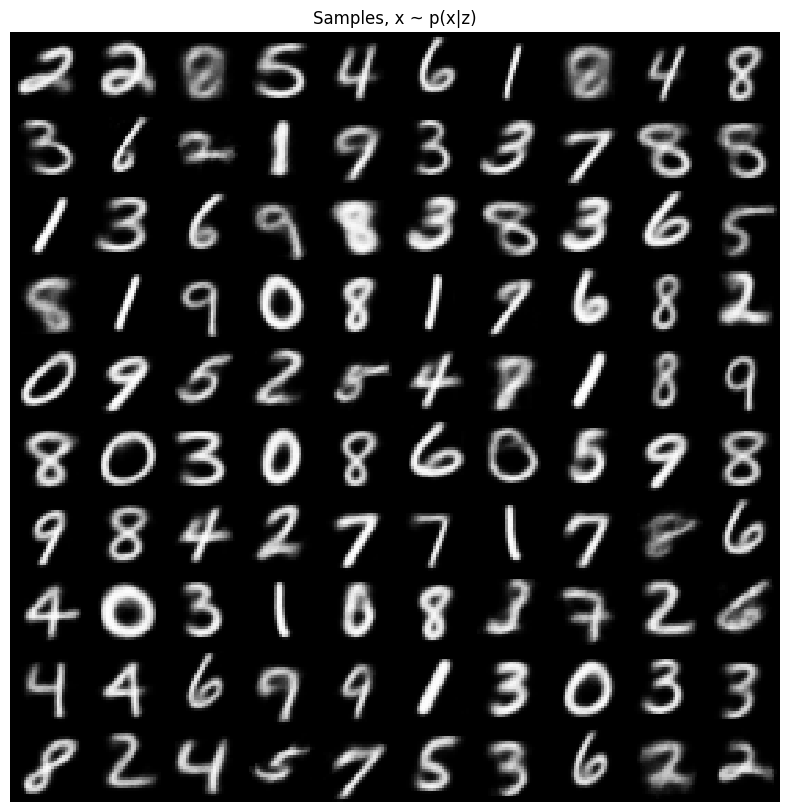

In [34]:
vae_p_x_samples = vae_p_x_samples.reshape(vae_p_x_samples.shape[0], 28, 28)
vae_p_x_samples = [x for x in vae_p_x_samples]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
plot_image_matrix(vae_p_x_samples, ax1)
ax1.set_title('Samples, x ~ p(x|z)')

Text(0.5, 1.0, 'Samples, x ~\xa0p(x|z)')

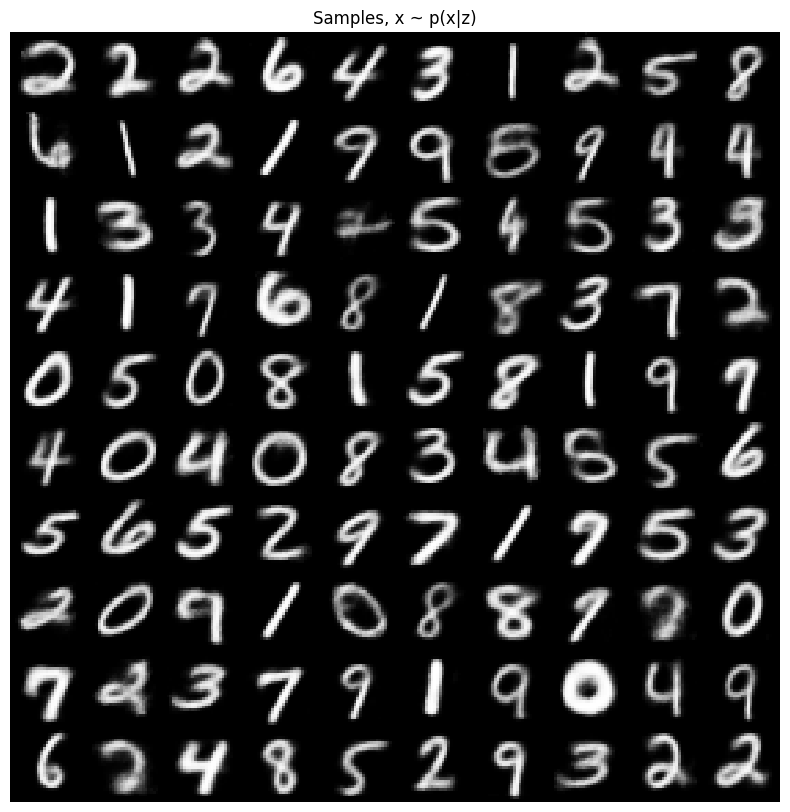

In [35]:
avae_p_x_samples = avae_p_x_samples.reshape(avae_p_x_samples.shape[0], 28, 28)
avae_p_x_samples = [x for x in avae_p_x_samples]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
plot_image_matrix(avae_p_x_samples, ax1)
ax1.set_title('Samples, x ~ p(x|z)')

Text(0.5, 1.0, 'Samples, x ~\xa0p(x|z)')

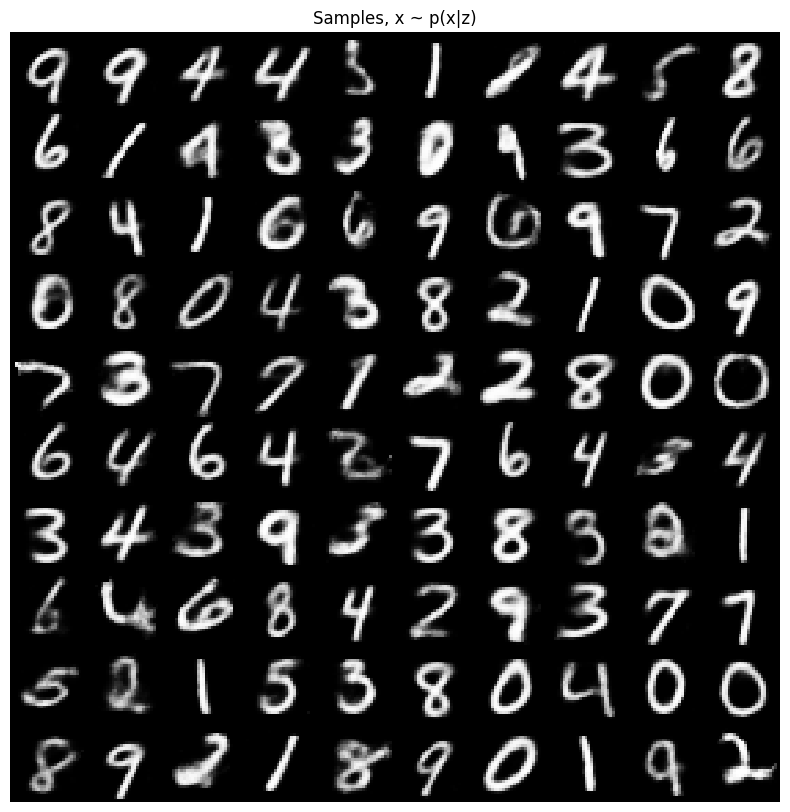

In [36]:
hvae_p_x_samples = hvae_p_x_samples.reshape(hvae_p_x_samples.shape[0], 28, 28)
hvae_p_x_samples = [x for x in hvae_p_x_samples]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
plot_image_matrix(hvae_p_x_samples, ax1)
ax1.set_title('Samples, x ~ p(x|z)')

## OOD detection based on ELBO

In [37]:
def compute_elbo_no_iw(model, x):
    with torch.no_grad():
        x = torch.FloatTensor(x)

        px, px_args = model.forward(x)

        kl_divergence = vae.kl_divergence
        likelihood = model.log_likelihood(x, *px_args)
        elbo = likelihood - kl_divergence

        return elbo, kl_divergence, likelihood

def compute_elbo_iw(model, x, importance_samples=1):
    with torch.no_grad():
        x = torch.FloatTensor(x)
        x = x.repeat(1, importance_samples).view(-1, x.shape[1])

        px, px_args = model.forward(x)

        kl_divergence = model.kl_divergence
        likelihood = model.log_likelihood(x, *px_args)
        elbo = likelihood - kl_divergence

        elbo_mean = vari.utilities.log_sum_exp(elbo.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)
        lielihood_mean = vari.utilities.log_sum_exp(likelihood.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)
        kl_divergence_mean = vari.utilities.log_sum_exp(kl_divergence.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)

        return elbo_mean, kl_divergence_mean, lielihood_mean

def compute_elbo(model, x, importance_samples=0):
    if importance_samples == 0:
        return compute_elbo_no_iw(model, x)
    return compute_elbo_iw(model, x, importance_samples)

### OOD between datasets

In [38]:
elbo_train, kl_train, likelihood_train = defaultdict(dict), defaultdict(dict), defaultdict(dict)
elbo_test1, kl_test1, likelihood_test1 = defaultdict(dict), defaultdict(dict), defaultdict(dict)
elbo_test2, kl_test2, likelihood_test2 = defaultdict(dict), defaultdict(dict), defaultdict(dict)
for dataset in ['MNISTBinarized', 'FashionMNISTBinarized']:
    # Define train and test data and load corresponding model
    x_train, x_test1, x_test2, y_train, y_test1, y_test2 = get_data(dataset)
    models = load_models(run_ids_all_labels[dataset])
    
    # Evaluate models on the datasets
    for model_abbr, model in models.items():
        print(dataset, model_abbr)
        elbo_train[dataset][model_abbr], kl_train[dataset][model_abbr], likelihood_train[dataset][model_abbr] = compute_elbo(model, x_train, importance_samples=10)
        elbo_test1[dataset][model_abbr], kl_test1[dataset][model_abbr], likelihood_test1[dataset][model_abbr] = compute_elbo(model, x_test1, importance_samples=10)
        elbo_test2[dataset][model_abbr], kl_test2[dataset][model_abbr], likelihood_test2[dataset][model_abbr] = compute_elbo(model, x_test2, importance_samples=10)
        print(f'\tTrain ELBO: {elbo_train[dataset][model_abbr].mean().item()}')
        print(f'\tTest1 ELBO: {elbo_test1[dataset][model_abbr].mean().item()}')
        print(f'\tTest2 ELBO: {elbo_test2[dataset][model_abbr].mean().item()}')

Loaded VAE ID 6243
Loaded AVAE ID 6278
Loaded HVAE ID 6263
MNISTBinarized vae
	Train ELBO: -116.96321868896484
	Test1 ELBO: -121.4813003540039
	Test2 ELBO: -806.100830078125
MNISTBinarized avae
	Train ELBO: -112.17743682861328
	Test1 ELBO: -118.65705108642578
	Test2 ELBO: -7.754968874750998e+21
MNISTBinarized hvae
	Train ELBO: -98.14303588867188
	Test1 ELBO: -107.30057525634766
	Test2 ELBO: -1116.354248046875
Loaded VAE ID 6253
Loaded AVAE ID 6286
Loaded HVAE ID 6256
FashionMNISTBinarized vae
	Train ELBO: -169.96527099609375
	Test1 ELBO: -170.337158203125
	Test2 ELBO: -235.5689697265625
FashionMNISTBinarized avae
	Train ELBO: -8.52160875801893e+21
	Test1 ELBO: -4.122759029921388e+22
	Test2 ELBO: -233.7477264404297
FashionMNISTBinarized hvae
	Train ELBO: -135.54193115234375
	Test1 ELBO: -140.57057189941406
	Test2 ELBO: -220.3155059814453


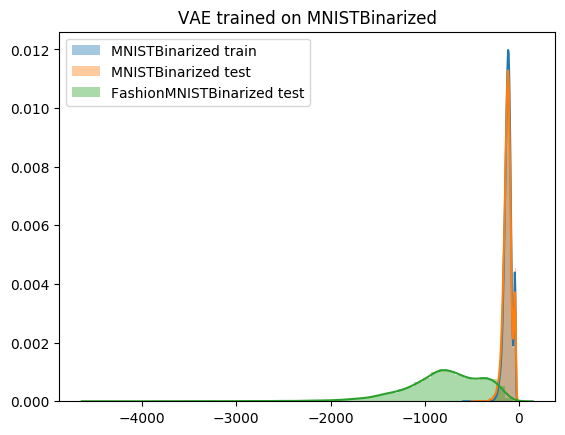

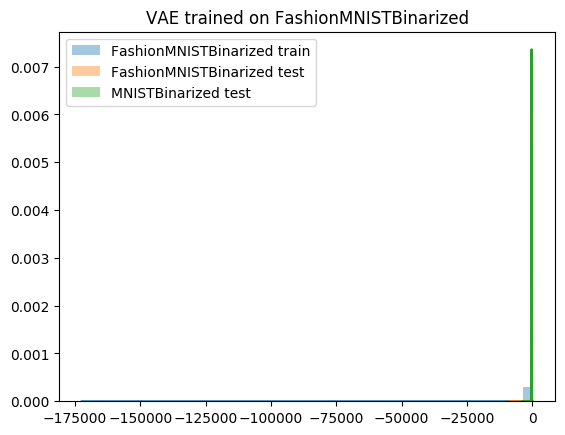

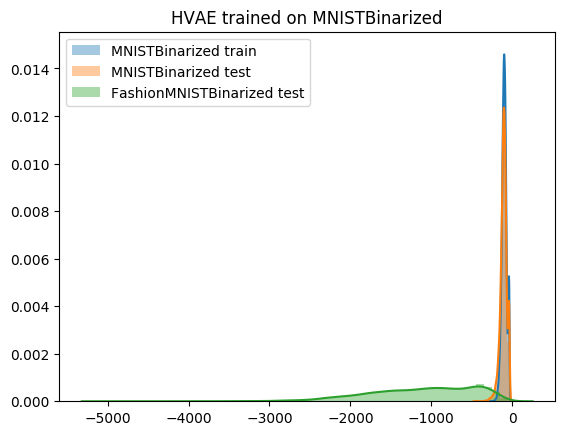

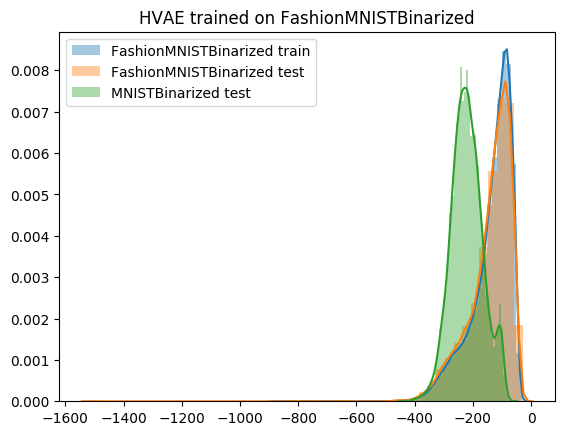

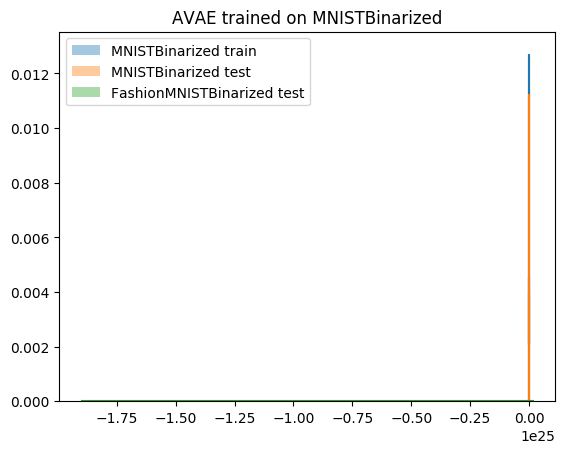

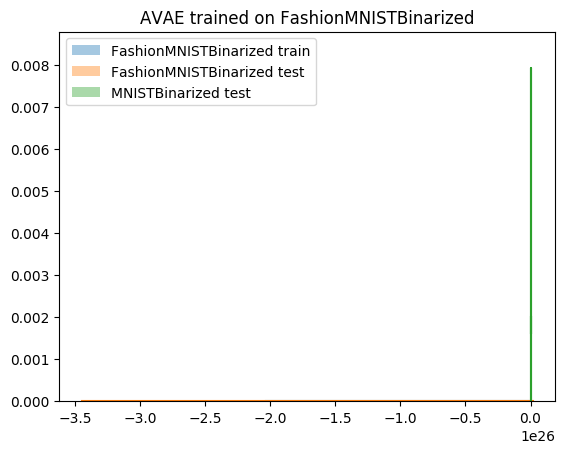

In [39]:
for model_abbr, run_id in run_ids_all_labels[dataset].items():
    for dataset in ['MNISTBinarized', 'FashionMNISTBinarized']:
        other_dataset = 'FashionMNISTBinarized' if dataset == 'MNISTBinarized' else 'MNISTBinarized'
        fig, ax1 = plt.subplots(1, 1)
        seaborn.distplot(elbo_train[dataset][model_abbr], ax=ax1, label=f'{dataset} train')
        seaborn.distplot(elbo_test1[dataset][model_abbr], ax=ax1, label=f'{dataset} test')
        seaborn.distplot(elbo_test2[dataset][model_abbr], ax=ax1, label=f'{other_dataset} test')
        ax1.set_title(f'{model_abbr.upper()} trained on {dataset}')
        ax1.legend()

In [13]:
def compute_elbo_no_iw_hvae(model, x):
    with torch.no_grad():
        x = torch.FloatTensor(x)

        latents = model.encode(x)
        x, px_args = model.decode(latents, copy_latents=[False, True])

        kl_divergence = vae.kl_divergence
        likelihood = model.log_likelihood(x, *px_args)
        elbo = likelihood - kl_divergence

        return elbo, kl_divergence, likelihood

def compute_elbo_iw_hvae(model, x, importance_samples=1):
    with torch.no_grad():
        x = torch.FloatTensor(x)
        x = x.repeat(1, importance_samples).view(-1, x.shape[1])

        latents = model.encode(x)
        x, px_args = model.decode(latents, copy_latents=[False, True])

        kl_divergence = model.kl_divergence
        likelihood = model.log_likelihood(x, *px_args)
        elbo = likelihood - kl_divergence

        elbo_mean = vari.utilities.log_sum_exp(elbo.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)
        lielihood_mean = vari.utilities.log_sum_exp(likelihood.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)
        kl_divergence_mean = vari.utilities.log_sum_exp(kl_divergence.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)

        return elbo_mean, kl_divergence_mean, lielihood_mean

def compute_elbo_hvae(model, x, importance_samples=0):
    if importance_samples == 0:
        return compute_elbo_no_iw_hvae(model, x)
    return compute_elbo_iw_hvae(model, x, importance_samples)

MNISTBinarized hvae
Loaded VAE ID 6243
Loaded AVAE ID 6278
Loaded HVAE ID 6263
	Train ELBO: -70.41315460205078
	Test1 ELBO: -70.32292175292969
	Test2 ELBO: -79.29792022705078
FashionMNISTBinarized hvae
Loaded VAE ID 6253
Loaded AVAE ID 6286
Loaded HVAE ID 6256
	Train ELBO: -147.2679901123047
	Test1 ELBO: -147.6891326904297
	Test2 ELBO: -144.0722198486328


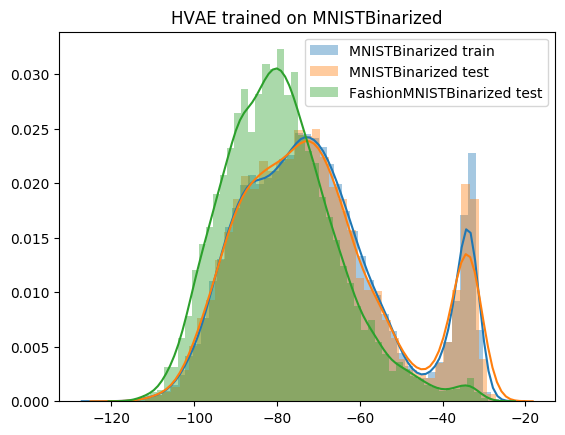

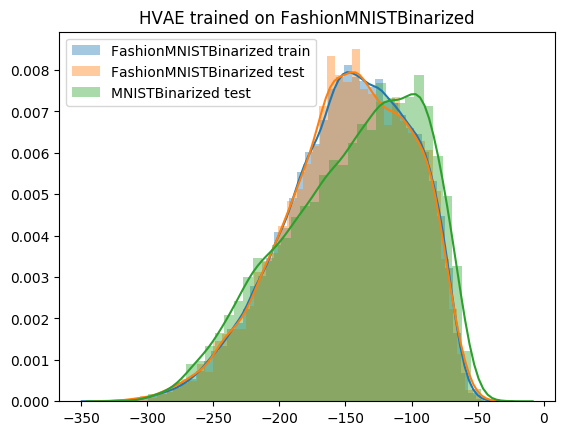

In [14]:
# HVAE sampling without copying low-level features (exclusively from q_2)
model_abbr = 'hvae'
for dataset in ['MNISTBinarized', 'FashionMNISTBinarized']:
    print(dataset, model_abbr)
    other_dataset = 'FashionMNISTBinarized' if dataset == 'MNISTBinarized' else 'MNISTBinarized'
    # Define train and test data and load corresponding model
    x_train, x_test1, x_test2, y_train, y_test1, y_test2 = get_data(dataset)
    models = load_models(run_ids_all_labels[dataset])
    model = models['hvae']
    
    hvae_elbo_train, kl_train, likelihood_train = compute_elbo_hvae(model, x_train, importance_samples=10)
    hvae_elbo_test1, kl_test1, likelihood_test1 = compute_elbo_hvae(model, x_test1, importance_samples=10)
    hvae_elbo_test2, kl_test2, likelihood_test2 = compute_elbo_hvae(model, x_test2, importance_samples=10)
    print(f'\tTrain ELBO: {hvae_elbo_train.mean().item()}')
    print(f'\tTest1 ELBO: {hvae_elbo_test1.mean().item()}')
    print(f'\tTest2 ELBO: {hvae_elbo_test2.mean().item()}')

    fig, ax1 = plt.subplots(1, 1)
    seaborn.distplot(hvae_elbo_train, ax=ax1, label=f'{dataset} train')
    seaborn.distplot(hvae_elbo_test1, ax=ax1, label=f'{dataset} test')
    seaborn.distplot(hvae_elbo_test2, ax=ax1, label=f'{other_dataset} test')
    ax1.set_title(f'{model_abbr.upper()} trained on {dataset}')
    ax1.legend()

MNISTBinarized hvae
Loaded VAE ID 6243
Loaded AVAE ID 6278
Loaded HVAE ID 6263
	Train ELBO: -78.2801742553711
	Test1 ELBO: -78.30485534667969
	Test2 ELBO: -89.85635375976562
FashionMNISTBinarized hvae
Loaded VAE ID 6253
Loaded AVAE ID 6286
Loaded HVAE ID 6256
	Train ELBO: -153.82691955566406
	Test1 ELBO: -154.6339569091797
	Test2 ELBO: -150.43653869628906


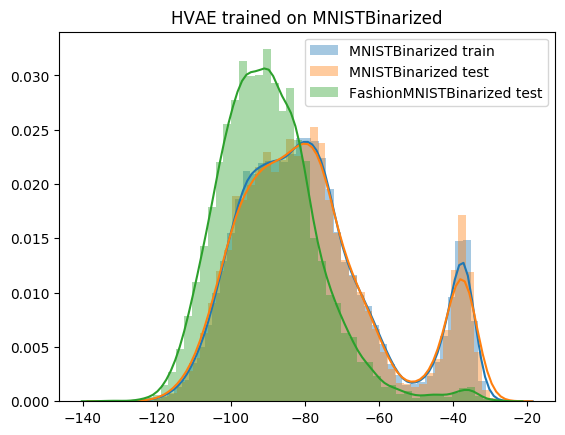

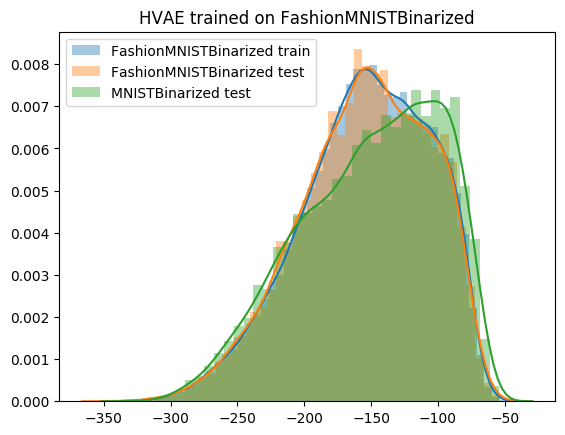

In [41]:
# HVAE sampling without copying low-level features (exclusively from q_2)
model_abbr = 'hvae'
for dataset in ['MNISTBinarized', 'FashionMNISTBinarized']:
    print(dataset, model_abbr)
    other_dataset = 'FashionMNISTBinarized' if dataset == 'MNISTBinarized' else 'MNISTBinarized'
    # Define train and test data and load corresponding model
    x_train, x_test1, x_test2, y_train, y_test1, y_test2 = get_data(dataset)
    models = load_models(run_ids_all_labels[dataset])
    model = models['hvae']
    
    hvae_elbo_train, kl_train, likelihood_train = compute_elbo_hvae(model, x_train, importance_samples=10)
    hvae_elbo_test1, kl_test1, likelihood_test1 = compute_elbo_hvae(model, x_test1, importance_samples=10)
    hvae_elbo_test2, kl_test2, likelihood_test2 = compute_elbo_hvae(model, x_test2, importance_samples=10)
    print(f'\tTrain ELBO: {hvae_elbo_train.mean().item()}')
    print(f'\tTest1 ELBO: {hvae_elbo_test1.mean().item()}')
    print(f'\tTest2 ELBO: {hvae_elbo_test2.mean().item()}')

    fig, ax1 = plt.subplots(1, 1)
    seaborn.distplot(hvae_elbo_train, ax=ax1, label=f'{dataset} train')
    seaborn.distplot(hvae_elbo_test1, ax=ax1, label=f'{dataset} test')
    seaborn.distplot(hvae_elbo_test2, ax=ax1, label=f'{other_dataset} test')
    ax1.set_title(f'{model_abbr.upper()} trained on {dataset}')
    ax1.legend()

### OOD between classes

In [42]:
def get_model_name_from_abbr(abbr):
    if abbr == 'vae':
        return 'VariationalAutoencoder'
    elif abbr == 'avae':
        return 'AuxilliaryVariationalAutoencoder'
    elif abbr == 'hvae':
        return 'HierarchicalVariationalAutoencoder'
    else:
        raise ValueError(abbr)

In [43]:
run_ids_excluded_labels

{'MNISTBinarized': {'vae': {'4': 6244, '8': 6250},
  'hvae': {'4': 6245, '8': 6251},
  'avae': {'4': 6246, '8': 6252}},
 'FashionMNISTBinarized': {'vae': {'0': 6247, '8': 6255},
  'hvae': {'0': 6248, '8': 6264},
  'avae': {'0': 6249, '8': 6284}}}

In [44]:
ood_models = dict()
for dataset, models in run_ids_excluded_labels.items():
    ood_models[dataset] = dict()
    
    for model_abbr, exclusions in models.items():
        ood_models[dataset][model_abbr] = dict()
        
        for excluded_label, run_id in exclusions.items():
            model_name = get_model_name_from_abbr(model_abbr)
            kwargs = vari.models.get_default_model_config(model_name, dataset)
            model = getattr(vari.models.vae, model_name)
            model = model(x_dim=784, **kwargs)
            try:
                model.load_state_dict(torch.load(
                    os.path.join(experiments_dir, str(run_id), 'model_state_dict.pkl'),
                    map_location=torch.device('cpu')
                ))
                ood_models[dataset][model][excluded_label] = model
            except Exception as exc:
                print(dataset, model_abbr, excluded_label)
                print(exc)
print(ood_models)

TypeError: type object got multiple values for keyword argument 'x_dim'

In [ ]:
for dataset in ['MNISTBinarized', 'FashionMNISTBinarized']:
    other_dataset = 'FashionMNISTBinarized' if dataset == 'MNISTBinarized' else 'MNISTBinarized'
    # Define train and test data and load corresponding model
    x_train, x_test1, x_test2, y_train, y_test1, y_test2 = get_data('MNISTBinarized')
    models = load_models(run_ids_all_labels[dataset])
    
    for model_abbr, model in models.items():
        vae_elbo_train, vae_kl_train, vae_likelihood_train = compute_elbo(model, x_train, importance_samples=10)
        vae_elbo_test1, vae_kl_test1, vae_likelihood_test1 = compute_elbo(model, x_test1, importance_samples=10)
        vae_elbo_test2, vae_kl_test2, vae_likelihood_test2 = compute_elbo(model, x_test2, importance_samples=10)

        fig, ax1 = plt.subplots(1, 1)
        seaborn.distplot(vae_elbo_train, ax=ax1, label=f'{dataset} train')
        seaborn.distplot(vae_elbo_test1, ax=ax1, label=f'{dataset} test')
        seaborn.distplot(vae_elbo_test2, ax=ax1, label=f'{other_dataset} test')
        ax1.set_title(f'{model_abbr.upper()} trained on {dataset}')
        ax1.legend()

In [ ]:
mnist_train = vari.datasets.MNISTBinarized(split='train', preprocess='static', exclude_labels=[], root=data_root)
mnist_test1 = vari.datasets.MNISTBinarized(split='test', preprocess='static', exclude_labels=[], root=data_root)

In [ ]:
fashion_mnist_train = vari.datasets.FashionMNISTBinarized(split='train', preprocess='static', exclude_labels=[], root=data_root)
fashion_mnist_test1 = vari.datasets.FashionMNISTBinarized(split='test', preprocess='static', exclude_labels=[], root=data_root)